In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models, datasets
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
import time
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# 複製數據到本地磁碟
drive_data_dir = '/content/drive/MyDrive/Colab Notebooks/data'
local_data_dir = '/content/data'
if not os.path.exists(local_data_dir):
    print("Copying data from Google Drive to local disk...")
    start_time = time.time()

    # 計算總檔案大小以顯示進度
    total_size = sum(os.path.getsize(os.path.join(dirpath, filename))
                    for dirpath, dirnames, filenames in os.walk(drive_data_dir)
                    for filename in filenames)

    # 使用 tqdm 顯示進度條
    with tqdm(total=total_size, unit='B', unit_scale=True, desc="Copying") as pbar:
        def copy_with_progress(src, dst, *, follow_symlinks=True):
            if os.path.isdir(src):
                os.makedirs(dst, exist_ok=True)
                for entry in os.scandir(src):
                    copy_with_progress(entry.path, os.path.join(dst, entry.name), follow_symlinks=follow_symlinks)
            else:
                shutil.copy2(src, dst, follow_symlinks=follow_symlinks)
                pbar.update(os.path.getsize(src))

        copy_with_progress(drive_data_dir, local_data_dir)

    end_time = time.time()
    print(f"Data copied in {end_time - start_time:.2f} seconds")
else:
    print("Data already exists in local disk")


# 更新路徑
train_dir = os.path.join(local_data_dir, 'train')
val_dir = os.path.join(local_data_dir, 'val')
test_dir = os.path.join(local_data_dir, 'test')

"""
# 檢查
print("Train directory contents:", os.listdir(train_dir))
print("Val directory contents:", os.listdir(val_dir))
print("Test directory contents:", os.listdir(test_dir))


# 數train所有資料夾裡有幾張圖
train_image_count = sum(len(files) for _, _, files in os.walk(train_dir))
print(f"Number of images in train directory: {train_image_count}")
val_image_count = sum(len(files) for _, _, files in os.walk(val_dir))
print(f"Number of images in train and val directory: {train_image_count+val_image_count}")

# 數test資料夾裡有幾張圖
test_image_count = sum(len(files) for _, _, files in os.walk(test_dir))
print(f"Number of images in test directory: {test_image_count}")
"""


Copying data from Google Drive to local disk...


Copying: 100%|██████████| 6.91G/6.91G [1:05:04<00:00, 1.77MB/s]

Data copied in 3944.58 seconds
Train directory contents: ['73', '19', '77', '41', '16', '06', '60', '92', '24', '96', '89', '94', '74', '10', '79', '86', '85', '54', '04', '39', '57', '46', '97', '11', '62', '37', '95', '14', '80', '03', '82', '69', '18', '34', '13', '91', '52', '21', '20', '66', '32', '25', '42', '44', '56', '33', '51', '23', '43', '81', '48', '36', '02', '.DS_Store', '08', '31', '01', '72', '55', '0', '83', '30', '26', '27', '64', '09', '49', '59', '05', '67', '35', '75', '93', '90', '50', '63', '88', '45', '22', '61', '78', '15', '40', '87', '84', '12', '65', '70', '98', '07', '68', '47', '71', '38', '76', '28', '29', '58', '53', '99', '17']
Val directory contents: ['73', '19', '77', '41', '16', '06', '60', '92', '24', '96', '89', '94', '74', '10', '79', '86', '85', '54', '04', '39', '57', '46', '97', '11', '62', '37', '95', '14', '80', '03', '82', '69', '18', '34', '13', '91', '52', '21', '20', '66', '32', '25', '42', '44', '56', '33', '51', '23', '43', '81', '48',

In [24]:
# 自定義數據集類（用於test資料夾）
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name  # 返回圖片和文件名

# 增強數據增強
train_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # 隨機旋轉 ±15 度
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # 平移和縮放
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))
])

test_transforms = transforms.Compose([
    # 將圖片縮放至224x224像素，確保與訓練集尺寸一致
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),
    # 將圖片轉換為PyTorch張量
    transforms.ToTensor(),
    # 與訓練集相同的標準化參數，保持一致性
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 加載數據
# 使用ImageFolder加載train和val數據（自動處理類別子資料夾0-99）
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=train_transforms)
test_dataset = TestImageDataset(test_dir, transform=test_transforms)


# 創建DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 確認數據量
print(f"Original train size: {len(train_dataset)}")
print(f"Original val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# 確認類別數量
print(f"Number of classes: {len(train_dataset.classes)}")  # 應為100
print(f"Class to index mapping: {train_dataset.class_to_idx}")  # 應為 {'0': 0, '1': 1, ..., '99': 99}

Original train size: 20982
Original val size: 300
Test size: 2344
Number of classes: 100
Class to index mapping: {'0': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 8

In [25]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        log_probs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()



In [28]:
# 定義模型
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # 增加一層
    nn.ReLU(),
    nn.BatchNorm1d(512),           # 添加 BatchNorm 穩定訓練
    nn.Linear(512, 100)            # 直接輸出，移除 256 層
)
model = model.to(device)


# 定義優化器，使用差分學習率
optimizer = optim.Adam([
    {'params': [p for n, p in model.named_parameters() if "fc" not in n], 'lr': 2e-5},
    {'params': model.fc.parameters(), 'lr': 2e-4}
], weight_decay=1e-3)


# Label Smoothing Loss
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# 學習率調度器
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

# 檢查參數數量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(model):,}")

Number of parameters: 24,609,444


In [ ]:
# 訓練模型並記錄損失
num_epochs = 15
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=True)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    # 驗證階段
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_bar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=True)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # 調整學習率
    scheduler.step()

    # 保存檢查點
    if (epoch + 1) % 5 == 0:
      checkpoint = {
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': avg_loss,
          'accuracy': accuracy,
      }
      torch.save(checkpoint, f'/content/drive/MyDrive/Colab Notebooks/checkpoint_epoch_{epoch+1}.pth')
      print(f"Checkpoint saved to /content/drive/MyDrive/Colab Notebooks/checkpoint_epoch_{epoch+1}.pth")


# 保存模型
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/resnet18_modified.pth')



Epoch [1/15] Training: 100%|██████████| 656/656 [05:44<00:00,  1.90it/s, loss=2.6955]


Epoch [1/15], Average Loss: 2.4259


Epoch [1/15] Validation: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Validation Loss: 2.1819, Accuracy: 55.33%


Epoch [2/15] Training: 100%|██████████| 656/656 [05:42<00:00,  1.91it/s, loss=1.6988]


Epoch [2/15], Average Loss: 1.7257


Epoch [2/15] Validation: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Validation Loss: 1.9721, Accuracy: 67.00%


Epoch [3/15] Training: 100%|██████████| 656/656 [05:45<00:00,  1.90it/s, loss=1.6245]


Epoch [3/15], Average Loss: 1.5418


Epoch [3/15] Validation: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Validation Loss: 1.8079, Accuracy: 69.00%


Epoch [4/15] Training: 100%|██████████| 656/656 [05:43<00:00,  1.91it/s, loss=1.4016]


Epoch [4/15], Average Loss: 1.4414


Epoch [4/15] Validation: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Validation Loss: 1.7380, Accuracy: 68.67%


Epoch [5/15] Training: 100%|██████████| 656/656 [05:44<00:00,  1.90it/s, loss=1.1456]


Epoch [5/15], Average Loss: 1.3704


Epoch [5/15] Validation: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Validation Loss: 1.7566, Accuracy: 71.00%
Checkpoint saved to /content/drive/MyDrive/Colab Notebooks/checkpoint_epoch_5.pth


Epoch [6/15] Training: 100%|██████████| 656/656 [05:45<00:00,  1.90it/s, loss=1.4908]


Epoch [6/15], Average Loss: 1.4584


Epoch [6/15] Validation: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Validation Loss: 1.7724, Accuracy: 73.67%


Epoch [7/15] Training: 100%|██████████| 656/656 [05:45<00:00,  1.90it/s, loss=1.1897]


Epoch [7/15], Average Loss: 1.3825


Epoch [7/15] Validation: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Validation Loss: 1.7595, Accuracy: 73.00%


Epoch [8/15] Training: 100%|██████████| 656/656 [05:44<00:00,  1.91it/s, loss=1.7723]


Epoch [8/15], Average Loss: 1.3102


Epoch [8/15] Validation: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Validation Loss: 1.6829, Accuracy: 74.67%


Epoch [9/15] Training: 100%|██████████| 656/656 [05:44<00:00,  1.90it/s, loss=1.1532]


Epoch [9/15], Average Loss: 1.2426


Epoch [9/15] Validation: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Validation Loss: 1.5848, Accuracy: 76.33%


Epoch [10/15] Training: 100%|██████████| 656/656 [05:43<00:00,  1.91it/s, loss=1.1525]


Epoch [10/15], Average Loss: 1.1986


Epoch [10/15] Validation: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Validation Loss: 1.5414, Accuracy: 77.00%
Checkpoint saved to /content/drive/MyDrive/Colab Notebooks/checkpoint_epoch_10.pth


Epoch [11/15] Training: 100%|██████████| 656/656 [05:44<00:00,  1.91it/s, loss=1.2894]


Epoch [11/15], Average Loss: 1.2784


Epoch [11/15] Validation: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Validation Loss: 1.6636, Accuracy: 76.33%


Epoch [12/15] Training:   1%|▏         | 9/656 [00:04<05:42,  1.89it/s, loss=1.3646]

ValueError: x and y must have same first dimension, but have shapes (25,) and (16,)

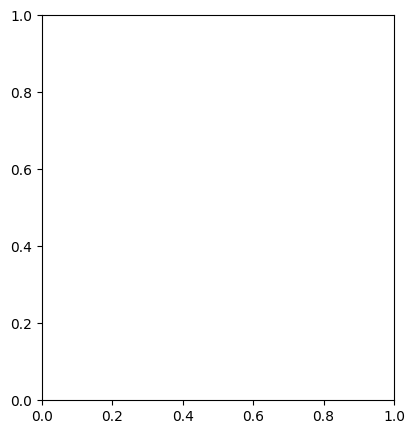

In [ ]:
# 繪製訓練曲線
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/training_curves.png')

In [22]:
# 以'/content/drive/MyDrive/Colab Notebooks/resnet18_modified.pth'開始test
#model_path = '/content/drive/MyDrive/Colab Notebooks/resnet18_modified.pth'
#model.load_state_dict(torch.load(model_path))

# 生成測試集預測
model.eval()
predictions = []
image_names = []

with torch.no_grad():
    total_batches = len(test_loader)
    for batch_idx, (images, img_names) in enumerate(tqdm(test_loader, desc="Generating Predictions with TTA", unit="batch", total=total_batches)):
        try:
            images = images.to(device)
            outputs = model(images) # 原圖預測
            images_flipped = torch.flip(images, dims=[3])   # 水平翻轉預測
            outputs_flipped = model(images_flipped)
            images_rotated = transforms.functional.rotate(images, 15)   # 旋轉 ±15 度預測
            outputs_rotated = model(images_rotated)
            images_bright = transforms.functional.adjust_brightness(images, 1.2)    # 亮度調整 (1.2x) 預測
            outputs_bright = model(images_bright)
            images_contrast = transforms.functional.adjust_contrast(images, 1.2)      # 對比度調整 (1.2x) 預測
            outputs_contrast = model(images_contrast)

            outputs = (outputs + outputs_flipped + outputs_rotated + outputs_bright + outputs_contrast) / 5

            _, preds = torch.max(outputs, 1)
            batch_preds = preds.cpu().numpy()

            if len(batch_preds) != len(img_names):
                print(f"Batch {batch_idx}: Mismatch! Predictions: {len(batch_preds)}, Image names: {len(img_names)}")
                print(f"Image names in this batch: {img_names}")
                continue
            predictions.extend(batch_preds)
            image_names.extend(img_names)
        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue

print(f"Length of image_names: {len(image_names)}")
print(f"Length of predictions: {len(predictions)}")


# 創建提交文件
submission_df = pd.DataFrame({
    'image_name': [name.rsplit('.', 1)[0] for name in image_names],  # 移除.jpg
    'pred_label': predictions
})
submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/prediction.csv', index=False)

from google.colab import files
files.download('/content/drive/MyDrive/Colab Notebooks/prediction.csv')

print("Prediction file 'prediction.csv' has been generated.")



Generating Predictions with TTA: 100%|██████████| 74/74 [00:30<00:00,  2.43batch/s]

Length of image_names: 2344
Length of predictions: 2344


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prediction file 'prediction.csv' has been generated.
